In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer#토큰 클래스
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import pandas as pd
data = pd.read_csv('spam (1).csv',encoding='latin1')[['v1','v2']]
data=data.rename(columns = {'v1':'y', 'v2' : 'X'})

class 영어_전처리기:
    def preprocessing(slef,X_text, remove_stopwords=False):
        X_text = BeautifulSoup(X_text, 'lxml').get_text()
        X_text = re.sub("[^a-zA-Z]", " ", X_text)
        words = X_text.lower().split()
        if remove_stopwords:
            stops = set(stopwords.words('english'))
            # stops.add(불용어 문자열)
            words = [w for w in words if not w in stops]
            clean_text = ' '.join(words)
        else:
            clean_text = ' '.join(words)

        return clean_text
    def __init__(self,data):#생성자(입력데이터를 받음)
        data['clean_X'] = data['X'].apply(lambda x: self.preprocessing(X_text=x, remove_stopwords=True))
        data['y_name'] = data['y']
        data['encoder_y'] = LabelEncoder().fit_transform(data['y'])
        data['categorical_y'] = list(to_categorical(data['encoder_y']))
        self.data=data
    def ck_m(self):
        print(f'결측치 확인:{self.data.isnull().values.any()}')
        print(f"X 중복 확인:{self.data['clean_X'].nunique(),len(self.data['clean_X'])}\n"
              f"y 중복 확인:{self.data['y'].nunique(),len(self.data['y'])}")
    def 전처리_결과_출력(self,n=1):#매개변수가 이미주어짐
        self.data['clean_X'] = self.data['clean_X'].str.replace("[^a-zA-Z0-9 ]", "")
        self.data['clean_X'] = self.data['clean_X'].str.replace('^ +', "")
        self.data['clean_X'].replace('', np.nan, inplace=True)
        self.data = self.data.dropna(how='any')
        if n==1:#이진분류면 다음을 실행
            Y = np.array(self.data['encoder_y'])
        else:#다중이면 다음을 실행
            Y = to_categorical(self.data['encoder_y'])
        X = np.array(self.data['clean_X'])
        x_data, test_x, y_data, test_y = train_test_split(X, Y, test_size=0.3, random_state=0)
        train_x, val_x, train_y, val_y = train_test_split(x_data, y_data, test_size=0.2, random_state=0)
        tk = Tokenizer()
        tk.fit_on_texts(train_x)
        n = len([d for d in sorted(list(tk.word_counts.items()), key=lambda x: x[1]) if d[1] > 4]) + 1

        token = Tokenizer(n)
        token.fit_on_texts(train_x)

        token_train_x = token.texts_to_sequences(train_x)
        token_test_x = token.texts_to_sequences(test_x)
        token_val_x = token.texts_to_sequences(val_x)
        drop_train = [index for index, sentence in enumerate(token_train_x) if len(sentence) < 1]
        drop_test = [index for index, sentence in enumerate(token_test_x) if len(sentence) < 1]
        drop_val = [index for index, sentence in enumerate(token_val_x) if len(sentence) < 1]
        token_train_x = np.delete(token_train_x, drop_train, axis=0)
        train_y = np.delete(train_y, drop_train, axis=0)
        token_test_x = np.delete(token_test_x, drop_test, axis=0)
        test_y = np.delete(test_y, drop_test, axis=0)
        token_val_x = np.delete(token_val_x, drop_val, axis=0)
        val_y = np.delete(val_y, drop_val, axis=0)
        w_l = max(len(pad_sequences(token_train_x)[0]),
                  len(pad_sequences(token_test_x)[0]),
                  len(pad_sequences(token_val_x)[0]))
        train_inputs = pad_sequences(token_train_x, maxlen=w_l)
        test_inputs = pad_sequences(token_test_x, maxlen=w_l)
        val_inputs = pad_sequences(token_val_x, maxlen=w_l)
        train_outputs = train_y
        test_outputs = test_y
        val_outputs = val_y
        return train_inputs,train_outputs,test_inputs,test_outputs,val_inputs,val_outputs,n
pr_mc=영어_전처리기(data)
pr_mc.ck_m()
t_x,t_y,tt_x,tt_y,v_x,v_y,n=pr_mc.전처리_결과_출력()
print(t_x.shape,t_y.shape,tt_x.shape,tt_y.shape,v_x.shape,v_y.shape,n)

결측치 확인:False
X 중복 확인:(5055, 5572)
y 중복 확인:(2, 5572)


C:\Users\ho316\AppData\Local\Temp/ipykernel_6640/122368909.py:39: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data['clean_X'] = self.data['clean_X'].str.replace("[^a-zA-Z0-9 ]", "")
C:\Users\ho316\AppData\Local\Temp/ipykernel_6640/122368909.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data['clean_X'] = self.data['clean_X'].str.replace('^ +', "")
C:\Users\ho316\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(3071, 54) (3071,) (1640, 54) (1640,) (756, 54) (756,) 1099


In [2]:
from tensorflow.keras.layers import Dense , Embedding,SimpleRNN,Dropout,LSTM,GRU,Layer,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [3]:
배치크기 = 128
총단어수= 1100
최고문장길이=54
임베딩길이=64
뉴런수=64
뉴런수2=32
d_out=0.5
ec=50
배치사이즈=64

In [4]:
es = EarlyStopping(monitor='val_loss',
                   mode='min', verbose=1, patience=4)
mc1 = ModelCheckpoint('best_e_m1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

m1 = Sequential()
m1.add(Embedding(총단어수, 임베딩길이))
m1.add(SimpleRNN(뉴런수,dropout=d_out,return_sequences=True)) 
m1.add(SimpleRNN(뉴런수2,dropout=d_out))
m1.add(Dense(1, activation='sigmoid'))
m1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history1 = m1.fit(t_x, t_y,epochs=ec,
                  callbacks=[es, mc1],batch_size=배치사이즈, 
                  validation_data=(v_x,v_y) )

Epoch 1/50
48/48 [==============================] - 3s 32ms/step - loss: 0.3227 - acc: 0.8877 - val_loss: 0.1933 - val_acc: 0.9458

Epoch 00001: val_acc improved from -inf to 0.94577, saving model to best_e_m1.h5
Epoch 2/50
48/48 [==============================] - 1s 23ms/step - loss: 0.1072 - acc: 0.9684 - val_loss: 0.1003 - val_acc: 0.9735

Epoch 00002: val_acc improved from 0.94577 to 0.97354, saving model to best_e_m1.h5
Epoch 3/50
48/48 [==============================] - 1s 23ms/step - loss: 0.0649 - acc: 0.9818 - val_loss: 0.0862 - val_acc: 0.9762

Epoch 00003: val_acc improved from 0.97354 to 0.97619, saving model to best_e_m1.h5
Epoch 4/50
48/48 [==============================] - 1s 23ms/step - loss: 0.0435 - acc: 0.9893 - val_loss: 0.0686 - val_acc: 0.9815

Epoch 00004: val_acc improved from 0.97619 to 0.98148, saving model to best_e_m1.h5
Epoch 5/50
48/48 [==============================] - 1s 21ms/step - loss: 0.0267 - acc: 0.9932 - val_loss: 0.0739 - val_acc: 0.9802

Epoch 0

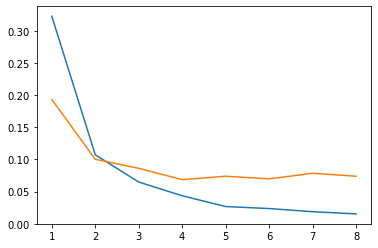

In [5]:
import matplotlib.pyplot as plt
ec=range(1,len(history1.history['acc'])+1)
plt.plot(ec,history1.history['loss'])
plt.plot(ec,history1.history['val_loss'])
plt.show()

In [6]:
ck1=m1.evaluate(tt_x, tt_y)

52/52 [==============================] - 0s 5ms/step - loss: 0.0757 - acc: 0.9811


In [7]:
배치크기 = 128
총단어수= 1100
최고문장길이=54
임베딩길이=64
뉴런수=64
뉴런수2=32
d_out=0.5
ec=50
배치사이즈=64

es = EarlyStopping(monitor='val_loss',
                   mode='min', verbose=1, patience=4)
mc2 = ModelCheckpoint('best_e_m2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

m2 = Sequential()
m2.add(Embedding(총단어수, 임베딩길이))
m2.add(LSTM(뉴런수,dropout=d_out,return_sequences=True)) 
m2.add(LSTM(뉴런수2,dropout=d_out))
m2.add(Dense(1, activation='sigmoid'))
m2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history2 = m2.fit(t_x, t_y,epochs=ec,
                  callbacks=[es, mc2],batch_size=배치사이즈, 
                  validation_data=(v_x,v_y) )

Epoch 1/50
48/48 [==============================] - 6s 67ms/step - loss: 0.4102 - acc: 0.8535 - val_loss: 0.2985 - val_acc: 0.8690

Epoch 00001: val_acc improved from -inf to 0.86905, saving model to best_e_m2.h5
Epoch 2/50
48/48 [==============================] - 2s 50ms/step - loss: 0.1612 - acc: 0.9499 - val_loss: 0.1060 - val_acc: 0.9709

Epoch 00002: val_acc improved from 0.86905 to 0.97090, saving model to best_e_m2.h5
Epoch 3/50
48/48 [==============================] - 2s 49ms/step - loss: 0.0690 - acc: 0.9837 - val_loss: 0.0657 - val_acc: 0.9815

Epoch 00003: val_acc improved from 0.97090 to 0.98148, saving model to best_e_m2.h5
Epoch 4/50
48/48 [==============================] - 2s 49ms/step - loss: 0.0444 - acc: 0.9889 - val_loss: 0.0607 - val_acc: 0.9841

Epoch 00004: val_acc improved from 0.98148 to 0.98413, saving model to best_e_m2.h5
Epoch 5/50
48/48 [==============================] - 2s 50ms/step - loss: 0.0299 - acc: 0.9925 - val_loss: 0.0613 - val_acc: 0.9854

Epoch 0

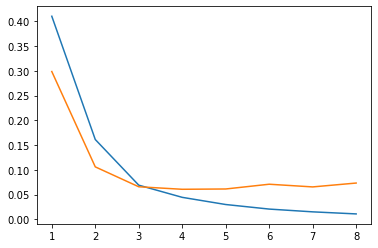

In [8]:
ec=range(1,len(history2.history['acc'])+1)
plt.plot(ec,history2.history['loss'])
plt.plot(ec,history2.history['val_loss'])
plt.show()

In [9]:
ck2=m2.evaluate(tt_x, tt_y)

52/52 [==============================] - 1s 10ms/step - loss: 0.0748 - acc: 0.9848


In [10]:
배치크기 = 128
총단어수= 1100
최고문장길이=54
임베딩길이=64
뉴런수=64
뉴런수2=32
d_out=0.5
ec=50
배치사이즈=64
es = EarlyStopping(monitor='val_loss',
                   mode='min', verbose=1, patience=4)
mc3 = ModelCheckpoint('best_e_m3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

m3 = Sequential()
m3.add(Embedding(총단어수, 임베딩길이))
m3.add(GRU(뉴런수,dropout=d_out,return_sequences=True)) 
m3.add(GRU(뉴런수2,dropout=d_out))
m3.add(Dense(1, activation='sigmoid'))
m3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history3 = m3.fit(t_x, t_y,epochs=ec,
                  callbacks=[es, mc3],batch_size=배치사이즈, 
                  validation_data=(v_x,v_y) )

Epoch 1/50
48/48 [==============================] - 6s 58ms/step - loss: 0.3564 - acc: 0.8785 - val_loss: 0.1733 - val_acc: 0.9431

Epoch 00001: val_acc improved from -inf to 0.94312, saving model to best_e_m3.h5
Epoch 2/50
48/48 [==============================] - 2s 48ms/step - loss: 0.0838 - acc: 0.9775 - val_loss: 0.0695 - val_acc: 0.9828

Epoch 00002: val_acc improved from 0.94312 to 0.98280, saving model to best_e_m3.h5
Epoch 3/50
48/48 [==============================] - 2s 49ms/step - loss: 0.0426 - acc: 0.9876 - val_loss: 0.0597 - val_acc: 0.9868

Epoch 00003: val_acc improved from 0.98280 to 0.98677, saving model to best_e_m3.h5
Epoch 4/50
48/48 [==============================] - 2s 47ms/step - loss: 0.0260 - acc: 0.9922 - val_loss: 0.0634 - val_acc: 0.9868

Epoch 00004: val_acc did not improve from 0.98677
Epoch 5/50
48/48 [==============================] - 2s 51ms/step - loss: 0.0175 - acc: 0.9951 - val_loss: 0.0669 - val_acc: 0.9868

Epoch 00005: val_acc did not improve from

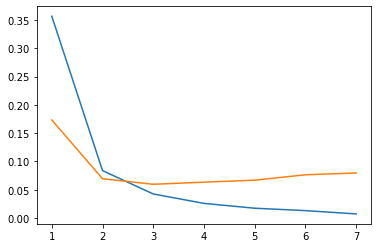

In [11]:
ec=range(1,len(history3.history['acc'])+1)
plt.plot(ec,history3.history['loss'])
plt.plot(ec,history3.history['val_loss'])
plt.show()

In [12]:
ck3=m3.evaluate(tt_x, tt_y)

52/52 [==============================] - 0s 8ms/step - loss: 0.0731 - acc: 0.9841


In [13]:
배치크기 = 128
총단어수= 1100
최고문장길이=54
임베딩길이=64
뉴런수=64
뉴런수2=32
d_out=0.5
ec=50
배치사이즈=64
es = EarlyStopping(monitor='val_loss',
                   mode='min', verbose=1, patience=4)
mc4 = ModelCheckpoint('best_e_m4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

m4 = Sequential()
m4.add(Embedding(총단어수, 임베딩길이))
m4.add(Bidirectional(LSTM(뉴런수,dropout=d_out,return_sequences=True)))
m4.add(Bidirectional(LSTM(뉴런수2,dropout=d_out)))
m4.add(Dense(1, activation='sigmoid'))
m4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history4 = m4.fit(t_x, t_y,epochs=ec,
                  callbacks=[es, mc4],batch_size=배치사이즈, 
                  validation_data=(v_x,v_y) )

Epoch 1/50
48/48 [==============================] - 10s 105ms/step - loss: 0.3803 - acc: 0.8681 - val_loss: 0.2477 - val_acc: 0.8677

Epoch 00001: val_acc improved from -inf to 0.86772, saving model to best_e_m4.h5
Epoch 2/50
48/48 [==============================] - 4s 89ms/step - loss: 0.1185 - acc: 0.9652 - val_loss: 0.0870 - val_acc: 0.9762

Epoch 00002: val_acc improved from 0.86772 to 0.97619, saving model to best_e_m4.h5
Epoch 3/50
48/48 [==============================] - 4s 83ms/step - loss: 0.0584 - acc: 0.9860 - val_loss: 0.0647 - val_acc: 0.9868

Epoch 00003: val_acc improved from 0.97619 to 0.98677, saving model to best_e_m4.h5
Epoch 4/50
48/48 [==============================] - 4s 83ms/step - loss: 0.0333 - acc: 0.9922 - val_loss: 0.0659 - val_acc: 0.9841

Epoch 00004: val_acc did not improve from 0.98677
Epoch 5/50
48/48 [==============================] - 4s 82ms/step - loss: 0.0222 - acc: 0.9958 - val_loss: 0.0707 - val_acc: 0.9868

Epoch 00005: val_acc did not improve fr

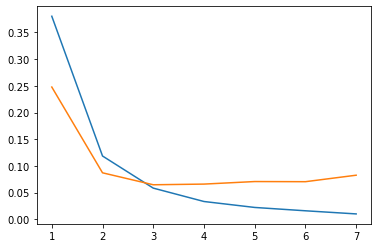

In [14]:
ec=range(1,len(history4.history['acc'])+1)
plt.plot(ec,history4.history['loss'])
plt.plot(ec,history4.history['val_loss'])
plt.show()

In [15]:
ck4=m4.evaluate(tt_x, tt_y)

52/52 [==============================] - 1s 12ms/step - loss: 0.0830 - acc: 0.9823


In [24]:
print(f'모델1:{ck1}')#RNN
print(f'모델2:{ck2}')#LSTM#best_e_m2.h5
print(f'모델3:{ck3}')#GRU
print(f'모델4:{ck4}')#양방향LSTM

모델1:[0.07571697235107422, 0.9810975790023804]
모델2:[0.07483036071062088, 0.9847561120986938]
모델3:[0.07305466383695602, 0.9841463565826416]
모델4:[0.08301953226327896, 0.9823170900344849]
